In [ ]:
import pandas as pd
import numpy  as np
from tqdm import tqdm  #for showing progress bars
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import copy

# Adding the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
xl = pd.read_csv('/content/drive/My Drive/task3/training_data_set_12_labeled_data.csv')
print("labeled data",xl.shape)
xul = pd.read_csv('/content/drive/My Drive/task3/training_data_set_12_unlabeled.csv')
print("unlabeled data",xul.shape)
yl = pd.read_csv('/content/drive/My Drive/task3/training_data_set_12_labeled_labels.csv')
print("labeled labels",yl.shape)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
labeled data (749, 36)
unlabeled data (1749, 36)
labeled labels (749, 1)


In [ ]:
input_l = torch.tensor(xl.values, dtype=torch.float32)  # labeled Features
target_l = torch.tensor(yl.values, dtype=torch.long)  # Labels
input_ul = torch.tensor(xul.values, dtype=torch.float32) # unlabeled features

In [ ]:
def get_dataloader(input_l, target_l, batch_size):
    dataset = TensorDataset(input_l, target_l)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Define a single autoencoder
class Autoencoder(nn.Module):
    def __init__(self, in1,h1,b1,h2):
        super(Autoencoder, self).__init__()

        # due to alternate linear and non linear layers in 5 layer AANN
        # used linear activation function
        # followed by tanh (non linear) activation function
        self.nl1 = nn.Linear(in1, h1)
        self.bl=nn.Linear(h1,b1)
        self.nl2=nn.Linear(b1,h2)
        self.l=nn.Linear(h2,in1)
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.tanh(self.nl1(x))
        x = self.bl(x)
        return x  # Encoded representation

    def forward(self, x):
        x = self.tanh(self.nl1(x))
        x=self.bl(x)
        x = self.tanh(self.nl2(x))
        x=self.l(x)
        return x # x is the output feature vector given by the model

In [ ]:
labeled_dataloader = get_dataloader(input_l, target_l, batch_size=75)
target_ul=input_ul
unlabeled_dataloader = get_dataloader(input_ul, target_ul, batch_size=175)


for batch_xl, batch_yl in labeled_dataloader:
    print("Labeled batch features shape:", batch_xl.shape)
    print("Labeled batch labels shape:", batch_yl.shape)
    break

# Check shapes for unlabeled data
for batch_xul in unlabeled_dataloader:
    print("Unlabeled batch features shape:", batch_xul[0].shape)
    break

Labeled batch features shape: torch.Size([75, 36])
Labeled batch labels shape: torch.Size([75, 1])
Unlabeled batch features shape: torch.Size([175, 36])


Pre-train 3 Autoencoders sequentially

In [ ]:
# Training function for an autoencoder
def train_autoencoder(x, model, num_epochs=2000, learning_rate=0.0005, threshold = 1e-6):
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    dataloader = get_dataloader(x, x, 175)
    losses = []


    for epoch in tqdm(range(num_epochs)):
        total_loss = 0
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            output = model(batch_x)  # model(x) invokes forward
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)

        # Compute relative error and check early stopping condition
        if epoch > 0:
            relative_error = abs(losses[-1] - losses[-2])
            if relative_error < threshold:
                print(f"Early stopping at epoch {epoch} (relative error < {threshold}")
                break


    return model, losses

In [ ]:
import matplotlib.pyplot as plt

 18%|█▊        | 359/2000 [00:15<01:10, 23.14it/s]


Early stopping at epoch 359 (relative error < 1e-06


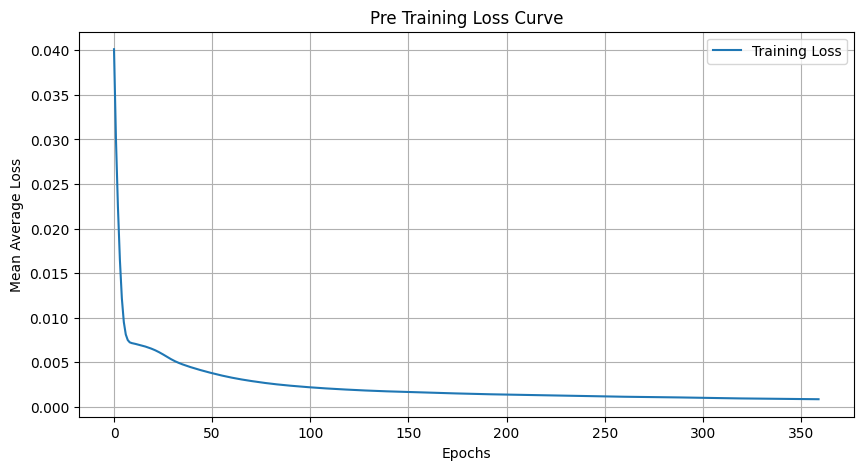

In [ ]:
model_1 = Autoencoder(36,30,26,30)
plt.figure(figsize=(10, 5))
model_1, losses_1 = train_autoencoder(input_ul, model_1)

plt.plot(range(len(losses_1)), losses_1, label="Training Loss")

plt.xlabel("Epochs")
plt.ylabel("Mean Average Loss")
plt.title("Pre Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-46-c8d51b28c8c6>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(model_1.encode(input_ul))
 17%|█▋        | 338/2000 [00:12<01:03, 26.22it/s]


Early stopping at epoch 338 (relative error < 1e-06


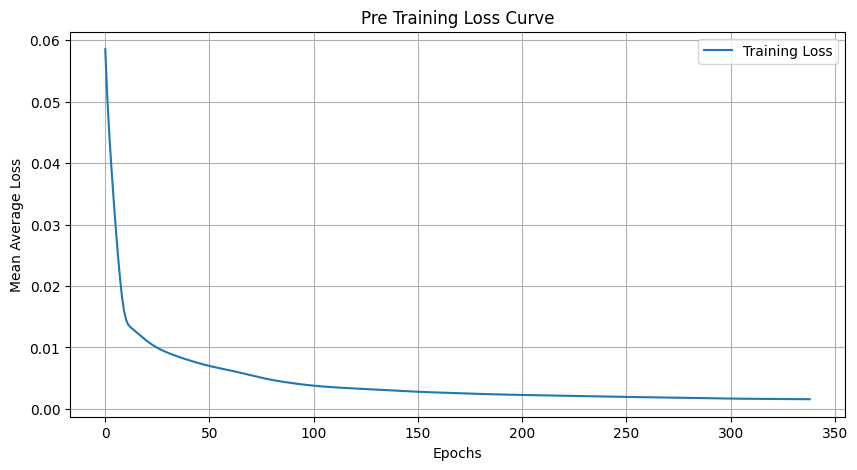

In [ ]:
x2 = torch.tensor(model_1.encode(input_ul))
model_2 = Autoencoder(26, 20, 16, 20)
plt.figure(figsize=(10, 5))
model_2, losses_2 = train_autoencoder(x2, model_2)

plt.plot(range(len(losses_2)), losses_2, label="Training Loss")

plt.xlabel("Epochs")
plt.ylabel("Mean Average Loss")
plt.title("Pre Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-47-ab5cf58fc9a1>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x3 = torch.tensor(model_2.encode(x2))
 24%|██▍       | 487/2000 [00:17<00:52, 28.62it/s]


Early stopping at epoch 487 (relative error < 1e-06


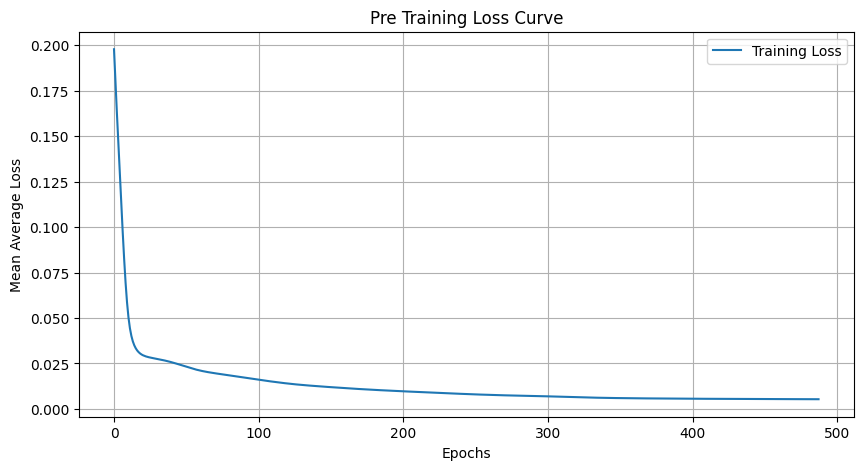

In [ ]:
x3 = torch.tensor(model_2.encode(x2))
model_3 = Autoencoder(16, 12, 9, 12)
plt.figure(figsize=(10, 5))
model_3, losses_3 = train_autoencoder(x3, model_3)

plt.plot(range(len(losses_3)), losses_3, label="Training Loss")

plt.xlabel("Epochs")
plt.ylabel("Mean Average Loss")
plt.title("Pre Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define the classifier using the trained encoders
class DFNN(nn.Module):
    def __init__(self, ae1, ae2, ae3, b3,  op=5):
        super(DFNN, self).__init__()

        # Use pretrained encoders from autoencoders
        self.encoder1 = copy.deepcopy(ae1.encode)
        self.encoder2 = copy.deepcopy(ae2.encode)
        self.encoder3 = copy.deepcopy(ae3.encode)
        self.fc_o = nn.Linear(b3, op)

    def forward(self, x):
        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        x = self.fc_o(x)
        return x

In [ ]:
# stack training for the DFNN
def train_dfnn(input_l, target_l, model_s, num_epochs=2000, learning_rate=0.0003, tol = 5e-7):
    criterion_s = nn.CrossEntropyLoss()
    optimizer_s = optim.Adam(model_s.parameters(), lr=learning_rate)
    dataloader = get_dataloader(input_l, target_l, 75)
    losses_stack = []

    for epoch in tqdm(range(num_epochs), desc="Training DFNN"):
        total_loss = 0
        for batch_x, batch_y in dataloader:
            optimizer_s.zero_grad()
            output = model_s(batch_x)
            loss = criterion_s(output, batch_y.squeeze(1))
            loss.backward()
            optimizer_s.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses_stack.append(avg_loss)

        if epoch > 0:
            relative_error = abs(losses_stack[-1] - losses_stack[-2])
            if relative_error < tol:
                print(f"Early stopping at epoch {epoch} (relative error < {tol}")
                break

    return model_s, losses_stack

Training DFNN:  35%|███▌      | 708/2000 [00:16<00:30, 42.10it/s]


Early stopping at epoch 708 (relative error < 5e-07


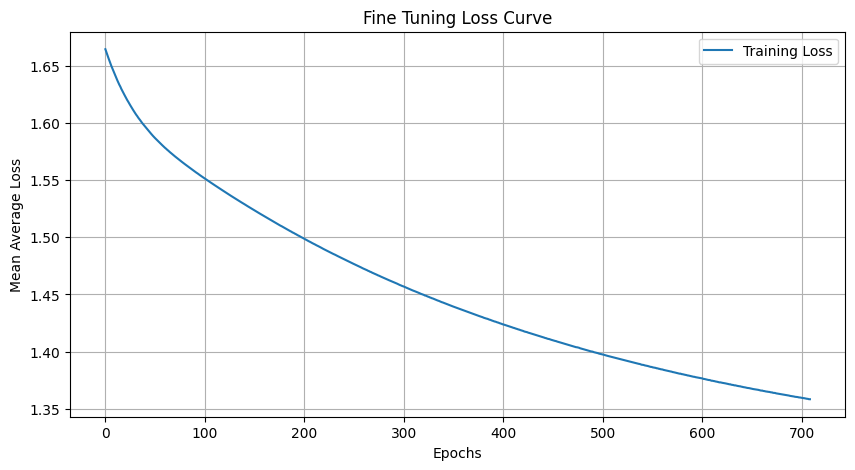

In [ ]:
plt.figure(figsize=(10, 5))
model_s = DFNN(model_1, model_2, model_3, b3 = 9, op=5)
model_s, losses_s = train_dfnn(input_l, target_l, model_s)

plt.plot(range(len(losses_s)), losses_s, label="Training Loss")

plt.xlabel("Epochs")
plt.ylabel("Mean Average Loss")
plt.title("Fine Tuning Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

Training DFNN:   9%|▊         | 171/2000 [00:04<00:52, 34.85it/s]


Early stopping at epoch 171 (relative error < 5e-07


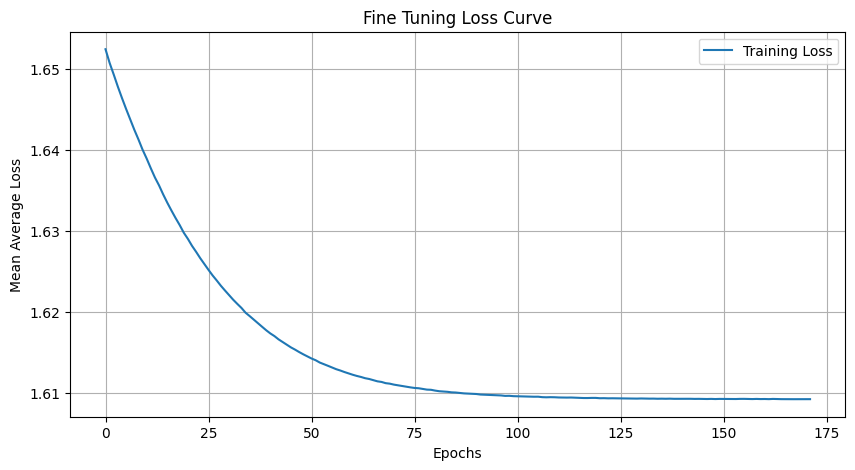

In [ ]:
plt.figure(figsize=(10, 5))
model1 = Autoencoder(36,30,26,30)
model2 = Autoencoder(26,20,16,20)
model3 = Autoencoder(16,12,9,12)
model_no_pre = DFNN(model1, model2, model3, b3 = 9, op=5)
model_no_pre, losses_no_pre = train_dfnn(input_l, target_l, model_no_pre)

plt.plot(range(len(losses_no_pre)), losses_no_pre, label="Training Loss")

plt.xlabel("Epochs")
plt.ylabel("Mean Average Loss")
plt.title("Fine Tuning Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

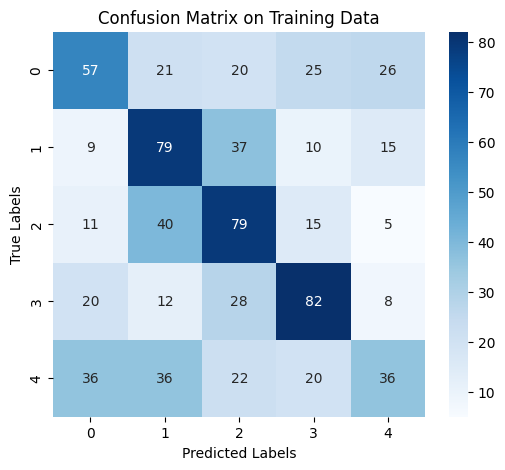

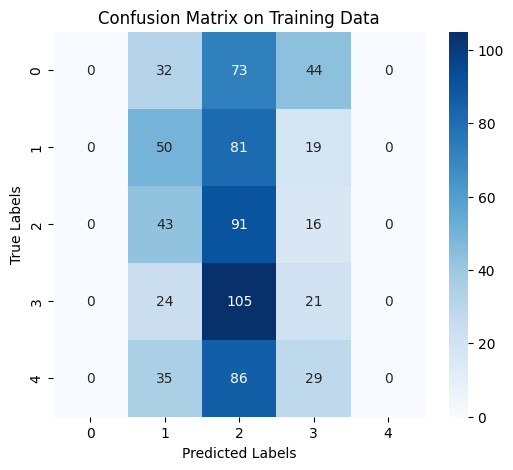

In [ ]:
# Function to evaluate the model on test data and plot confusion matrix
def evaluate_model(model, test_features, test_labels):
    model.eval()  # Set model to evaluation mode

    # Get predictions
    with torch.no_grad():
        outputs = model(test_features)  # Forward pass
        predicted_labels = torch.argmax(outputs, dim=1)  # Get class with highest probability

    # Convert test labels to 1D tensor
    test_labels = test_labels.squeeze(1)

    # Compute confusion matrix
    cm = confusion_matrix(test_labels.cpu().numpy(), predicted_labels.cpu().numpy())

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix on Training Data")
    plt.show()

# Run model on test data and plot confusion matrix
evaluate_model(model_s, input_l, target_l)
evaluate_model(model_no_pre, input_l, target_l)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
inp = pd.read_csv('/content/drive/My Drive/task3/testing_data_set_12_data.csv')
print("labeled data",inp.shape)
oup = pd.read_csv('/content/drive/My Drive/task3/testing_data_set_12_labels.csv')
print("unlabeled data",oup.shape)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
labeled data (249, 36)
unlabeled data (249, 1)


In [ ]:
inps = torch.tensor(inp.values, dtype=torch.float32)  # labeled Features
oups = torch.tensor(oup.values, dtype=torch.long)

Test Accuracy: 49.00%


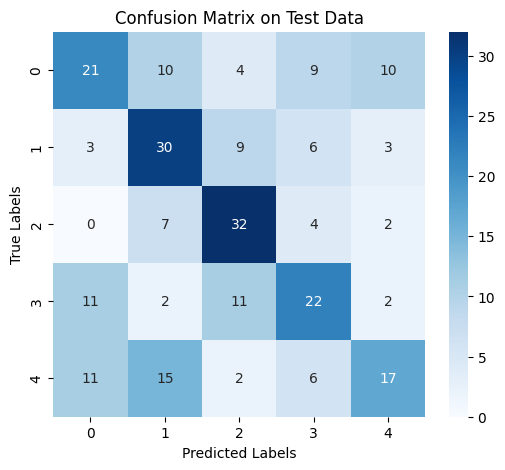

Test Accuracy: 20.08%


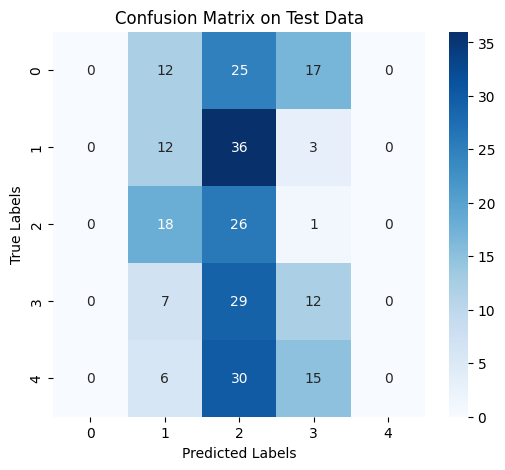

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# Function to evaluate the model on test data and plot confusion matrix
def evaluate_model(model, test_features, test_labels):
    model.eval()  # Set model to evaluation mode

    # Get predictions
    with torch.no_grad():
        outputs = model(test_features)  # Forward pass
        predicted_labels = torch.argmax(outputs, dim=1)  # Get class with highest probability

    # Convert test labels to 1D tensor
    test_labels = test_labels.squeeze(1)

    # Compute accuracy
    acc = accuracy_score(test_labels.cpu().numpy(), predicted_labels.cpu().numpy())
    print(f"Test Accuracy: {acc * 100:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(test_labels.cpu().numpy(), predicted_labels.cpu().numpy())

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix on Test Data")
    plt.show()

# Run model on test data and plot confusion matrix
evaluate_model(model_s, inps, oups)
evaluate_model(model_no_pre, inps, oups)